# Deep learning Keras-based solution of the MNIST problem

## 1. Load data

In [1]:
# Todo stop the numbers to vary from time to time
# Todo add K-fold
# Todo add a pipeline to scale params
# Todo choose the best params and cnn architecture
# Todo implement augmentation
# Todo try to get a pretrained cnn
# Todo early stop
# Todo print the numbers in square like in the book

In [2]:
_seed = 1337

In [3]:
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
log = logging.getLogger()

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path

import argparse
args = argparse.Namespace()
args.raw_train = pd.read_csv('../data/train.csv.zip')
args.raw_test = pd.read_csv('../data/test.csv.zip')
args.predictions_folder = Path('../predictions')

args.n_splits = 5
args.n_jobs = -1
args.val_fraction = 0.1
args.epochs = 50
args.model_name = 'deep-learning-keras-model.hdf5'
args.seed=_seed

args.train = args.raw_train.iloc[:, 1:].copy()
args.labels = args.raw_train['label'].copy()
args.test = args.raw_test.copy()

args.run_baseline = False
args.run_early_stop = False
args.run_grid_search = True
args.run_kfold_validation = True

args.predictions_folder.mkdir(parents=True, exist_ok=True) 

In [5]:
args.raw_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
args.raw_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
args.raw_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [8]:
def plot_number(label, pixels_2d, size_inches=None):
    title = args.raw_train.iloc[random_row, 0]
    fig, ax = plt.subplots()
    if size_inches:
        fig.set_size_inches(size_inches[0], size_inches[1])
    ax.set_title(label)
    imgplot = ax.imshow(pixels_2d)

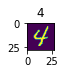

In [9]:
# Matlbab state-based style of image rendering 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_row = random.randrange(0, args.raw_train.shape[0], 1)
label = args.raw_train.iloc[random_row, 0]
pixels_2d = args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28)
plot_number(label, pixels_2d, (0.5, 0.5))

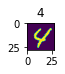

In [10]:
# OO-style image rendering
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_row = random.randrange(0, args.raw_train.shape[0], 1)
label = args.raw_train.iloc[random_row, 0]
pixels_2d = args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28)
plot_number(label, pixels_2d, (0.5, 0.5))

## 2. Training

In [11]:
import sklearn.utils.multiclass

X = args.train.to_numpy().reshape(args.train.shape[0], 28, 28, 1)
y = pd.get_dummies(args.labels, prefix='label').to_numpy()
y_sparse = args.labels.to_numpy()
x = args.test.to_numpy().reshape(args.test.shape[0], 28, 28, 1)

log.info('X.shape: %s', repr(X.shape))
log.info('X[0][14][14]: %s', X[0][14][14])

log.info('y.shape: %s', repr(y.shape))
log.info('y[0], %s', y[0])
log.info('type of target y: %s', repr(sklearn.utils.multiclass.type_of_target(y)))

log.info('y_sparse.shape: %s', repr(y_sparse.shape))
log.info('y_sparse: %s', repr(y_sparse))
log.info('y_sparse[0]: %s', y_sparse[0])
log.info('type of target y_sparse: %s', repr(sklearn.utils.multiclass.type_of_target(y_sparse)))

2020-07-14 23:46:55,020 : INFO : X.shape: (42000, 28, 28, 1)
2020-07-14 23:46:55,020 : INFO : X[0][14][14]: [254]
2020-07-14 23:46:55,021 : INFO : y.shape: (42000, 10)
2020-07-14 23:46:55,022 : INFO : y[0], [0 1 0 0 0 0 0 0 0 0]
2020-07-14 23:46:55,027 : INFO : type of target y: 'multilabel-indicator'
2020-07-14 23:46:55,028 : INFO : y_sparse.shape: (42000,)
2020-07-14 23:46:55,028 : INFO : y_sparse: array([1, 0, 1, ..., 7, 6, 9])
2020-07-14 23:46:55,029 : INFO : y_sparse[0]: 1
2020-07-14 23:46:55,031 : INFO : type of target y_sparse: 'multiclass'


In [12]:
def csv_sparse_predictions(predictions_sparse, filename):
    image_ids = np.arange(1, len(predictions_sparse) + 1)
    submission = pd.DataFrame({'ImageId': image_ids, 'Label': predictions_sparse})
    filepath = args.predictions_folder/filename
    
    submission.to_csv(filepath, index=False)
    log.info('Saved file: %s', filepath)
    
def csv_predictions(predictions, filename):
    log.debug('predictions.shape: %s', repr(predictions.shape))
    predictions_sparse = np.argmax(predictions, axis=1)
    csv_sparse_predictions(predictions_sparse, filename)

In [13]:
def plot_history(history):
    log.info("History keys: %s", history.history.keys())
    # Accuracy
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(history.history['accuracy'], label='Train')
    ax.plot(history.history['val_accuracy'], label='Test')
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.grid(True)
    ax.legend(['Train', 'Val'], loc='lower right')
    
    # Loss
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.grid()
    plt.show()

In [14]:
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier

def cross_val_score_sklearn(sklearn_model, X, y, scoring='accuracy', n_splits=args.n_splits, fit_params=None):
    cvs = cross_val_score(sklearn_model, X, y, cv=n_splits, n_jobs=args.n_jobs, fit_params=fit_params)
    log.info('CV mean accuracy: %0.5f. std: %0.5f', cvs.mean(), cvs.std())
    return cvs
    
def cross_val_score_keras(keras_model_builder, X, y, scoring='accuracy', n_splits=args.n_splits, fit_params={'epochs': args.epochs}):
    keras_classifier = KerasClassifier(keras_model_builder)
    return cross_val_score_sklearn(keras_classifier, X, y, scoring=scoring, n_splits=n_splits, fit_params=fit_params)

In [15]:
from keras import models

def build_model(layers_list, optimizer='rmsprop',
                loss='sparse_categorical_crossentropy', metrics_tuple=('accuracy')):
    model = models.Sequential(layers_list)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metrics_tuple])
    log.info(model.summary())
    return model

### 2.1 Baseline

In [16]:
from keras import layers 

def build_baseline_model_sparse():
    layers_list = [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ]
    return build_model(layers_list=layers_list)

In [17]:
%%time

def baseline():
    model = build_baseline_model_sparse()
    history = model.fit(X, y_sparse, validation_split=args.val_fraction, epochs=args.epochs, batch_size=64, verbose=1)
    plot_history(history)
    predictions = model.predict(x)
    csv_predictions(predictions, 'cnn_baseline_predictions.csv')
    if args.run_kfold_validation:
        cross_val_score_keras(build_baseline_model_sparse, X, y_sparse)
    
if args.run_baseline:
    baseline()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


### 2.2 Early stop

In [18]:
%%time

from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def early_stop(monitor='val_loss'):
    # val_loss
    # val_accuracy
    early_stopping = EarlyStopping(monitor=monitor, patience=10, mode='auto', verbose=1)
    model_checkpoint = ModelCheckpoint(args.model_name, save_best_only=True, monitor=monitor, mode='auto', verbose=1)
    reduce_lr_on_plateau = ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=3, verbose=1, min_delta=1e-4, mode='auto')

    model = build_baseline_model_sparse()
    history = model.fit(X, y_sparse, validation_split=args.val_fraction, epochs=args.epochs, batch_size=64, verbose=1, callbacks=[early_stopping, model_checkpoint, reduce_lr_on_plateau])

    plot_history(history)
    model.load_weights(args.model_name)
    predictions = model.predict(x)
    csv_predictions(predictions, 'cnn_early_stop_predictions.csv')
    
    if args.run_kfold_validation:
        cross_val_score_keras(build_baseline_model_sparse, X, y_sparse, fit_params={'validation_split': args.val_fraction, 'epochs': args.epochs, 'batch_size': 64, 'callbacks': [early_stopping, model_checkpoint, reduce_lr_on_plateau]})

if args.run_early_stop:
    early_stop(monitor='val_accuracy')

ModuleNotFoundError: No module named 'keras.callbacks.callbacks'; 'keras.callbacks' is not a package

### 2.3 Basic grid search to choose the best architecture

In [28]:
%%time 

# Todo check metrics for keras and grid search

from keras import layers 
from keras import models
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from pathlib import Path


def grid_search():
    layers_candidates = {
        1: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')],

#         2: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#         layers.MaxPooling2D((2, 2)),
#         layers.Conv2D(64, (3, 3), activation='relu'),
#         layers.MaxPooling2D((2, 2)),
#         layers.Conv2D(128, (3, 3), activation='relu'),
#         layers.Flatten(),
#         layers.Dense(128, activation='relu'),
#         layers.Dense(10, activation='softmax')],

#         3: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#         layers.MaxPooling2D((2, 2)),
#         layers.Conv2D(64, (3, 3), activation='relu'),
#         layers.Flatten(),
#         layers.Dense(64, activation='relu'),
#         layers.Dense(10, activation='softmax')],

#         4: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#         layers.Flatten(),
#         layers.Dense(64, activation='relu'),
#         layers.Dense(10, activation='softmax')],
    }
    
    def _build_model_grid_search(layers_candidates_key=1):
        return build_model(layers_candidates[layers_candidates_key])
    
    keras_classifier = KerasClassifier(_build_model_grid_search, 
                                       layers_candidates_key=1)
    # scoring='neg_log_loss'
    gcv = GridSearchCV(keras_classifier,
                         param_grid={'epochs': [40], 
                                     'layers_candidates_key': list(layers_candidates.keys())},
                         cv=args.n_splits,
                         scoring='accuracy',
                         n_jobs=args.n_jobs,
                         verbose=2)
    gcv.fit(X, y_sparse)
    log.info('Best params: %s', repr(gcv.best_params_))
    log.info('Best CV score: %s', repr(gcv.best_score_))
    log.info('Best std: %s', repr(gcv.cv_results_['std_test_score'][gcv.best_index_]))
    predictions = gcv.best_estimator_.predict(x)
    csv_sparse_predictions(predictions, 'cnn_basic_grid_search.csv')
    return gcv, layers_candidates[gcv.best_params_['layers_candidates_key']]
    
if args.run_grid_search:
    gcv, layers_list = grid_search()
    if args.run_kfold_validation:
        tmp_model_path = Path('/tmp/model.h5')
        if tmp_model_path.exists():
            tmp_model_path.unlink() 
        skf = StratifiedKFold(n_splits=args.n_splits, shuffle=True, random_state=args.seed)
        val_accuracies = np.array([])
        for train_index, val_index in skf.split(X, y_sparse):
            if tmp_model_path.exists():
                best_grid_search_model = models.load_model(tmp_model_path)
            else: 
                best_grid_search_model = build_model(layers_list)
                best_grid_search_model.save(tmp_model_path)
            history = best_grid_search_model.fit(X[train_index], y_sparse[train_index], validation_data=(X[val_index], y_sparse[val_index]), epochs=gcv.best_params_['epochs'], batch_size=64, verbose=1)
            scores = best_grid_search_model.evaluate(X[val_index], y_sparse[val_index], verbose=0)
            log.info('Iteration validation score: %s', repr(scores))
            val_accuracies = np.append(val_accuracies, scores[1])
        log.info('CV accuracy: %0.5f, std: ±%0.5f', np.mean(val_accuracies), np.std(val_accuracies))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 20.7min remaining: 13.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 20.7min finished
2020-07-15 13:11:48,263 : INFO : None


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                3

2020-07-15 13:20:27,923 : INFO : Best params: {'epochs': 40, 'layers_candidates_key': 1}
2020-07-15 13:20:27,924 : INFO : Best CV score: 0.9857380952380952
2020-07-15 13:20:27,924 : INFO : Best std: 0.0022767682072156186
2020-07-15 13:20:29,993 : INFO : Saved file: ../predictions/cnn_basic_grid_search.csv
2020-07-15 13:20:30,074 : INFO : None


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

2020-07-15 13:26:42,646 : INFO : Iteration validation score: [0.37662479281425476, 0.9940476417541504]


Epoch 1/40
525/525 [==============================] - 10s 19ms/step - loss: 0.0929 - accuracy: 0.9955 - val_loss: 0.1776 - val_accuracy: 0.9946
Epoch 2/40
525/525 [==============================] - 10s 19ms/step - loss: 0.0698 - accuracy: 0.9945 - val_loss: 0.0539 - val_accuracy: 0.9939
Epoch 3/40
525/525 [==============================] - 9s 18ms/step - loss: 0.0584 - accuracy: 0.9945 - val_loss: 0.0980 - val_accuracy: 0.9958
Epoch 4/40
525/525 [==============================] - 10s 18ms/step - loss: 0.0802 - accuracy: 0.9963 - val_loss: 0.0270 - val_accuracy: 0.9961
Epoch 5/40
525/525 [==============================] - 10s 18ms/step - loss: 0.0566 - accuracy: 0.9954 - val_loss: 0.0691 - val_accuracy: 0.9973
Epoch 6/40
525/525 [==============================] - 10s 18ms/step - loss: 0.0662 - accuracy: 0.9966 - val_loss: 0.0587 - val_accuracy: 0.9963
Epoch 7/40
525/525 [==============================] - 9s 17ms/step - loss: 0.0352 - accuracy: 0.9976 - val_loss: 0.0393 - val_accuracy: 0

2020-07-15 13:33:07,270 : INFO : Iteration validation score: [0.4548908770084381, 0.9961904883384705]


Epoch 1/40
525/525 [==============================] - 9s 17ms/step - loss: 0.0990 - accuracy: 0.9948 - val_loss: 0.0823 - val_accuracy: 0.9930
Epoch 2/40
525/525 [==============================] - 9s 17ms/step - loss: 0.0745 - accuracy: 0.9948 - val_loss: 0.0445 - val_accuracy: 0.9974
Epoch 3/40
525/525 [==============================] - 9s 17ms/step - loss: 0.0683 - accuracy: 0.9958 - val_loss: 0.0344 - val_accuracy: 0.9946
Epoch 4/40
525/525 [==============================] - 9s 17ms/step - loss: 0.0503 - accuracy: 0.9968 - val_loss: 0.0891 - val_accuracy: 0.9945
Epoch 5/40
525/525 [==============================] - 10s 19ms/step - loss: 0.0500 - accuracy: 0.9960 - val_loss: 0.0486 - val_accuracy: 0.9961
Epoch 6/40
525/525 [==============================] - 11s 21ms/step - loss: 0.0497 - accuracy: 0.9966 - val_loss: 0.0980 - val_accuracy: 0.9963
Epoch 7/40
525/525 [==============================] - 10s 18ms/step - loss: 0.0902 - accuracy: 0.9961 - val_loss: 0.0630 - val_accuracy: 0.9

2020-07-15 13:39:34,043 : INFO : Iteration validation score: [0.22626060247421265, 0.9964285492897034]


Epoch 1/40
525/525 [==============================] - 9s 17ms/step - loss: 0.0875 - accuracy: 0.9951 - val_loss: 0.0582 - val_accuracy: 0.9968
Epoch 2/40
525/525 [==============================] - 9s 17ms/step - loss: 0.0718 - accuracy: 0.9956 - val_loss: 0.0610 - val_accuracy: 0.9950
Epoch 3/40
525/525 [==============================] - 9s 17ms/step - loss: 0.0803 - accuracy: 0.9961 - val_loss: 0.0379 - val_accuracy: 0.9973
Epoch 4/40
525/525 [==============================] - 9s 18ms/step - loss: 0.0492 - accuracy: 0.9958 - val_loss: 0.0392 - val_accuracy: 0.9980
Epoch 5/40
525/525 [==============================] - 10s 19ms/step - loss: 0.0607 - accuracy: 0.9961 - val_loss: 0.0739 - val_accuracy: 0.9963
Epoch 6/40
525/525 [==============================] - 9s 18ms/step - loss: 0.0526 - accuracy: 0.9960 - val_loss: 0.0618 - val_accuracy: 0.9960
Epoch 7/40
525/525 [==============================] - 10s 18ms/step - loss: 0.0521 - accuracy: 0.9959 - val_loss: 0.0408 - val_accuracy: 0.99

2020-07-15 13:45:45,752 : INFO : Iteration validation score: [0.2386452555656433, 0.9936904907226562]


Epoch 1/40
525/525 [==============================] - 8s 15ms/step - loss: 0.0775 - accuracy: 0.9951 - val_loss: 0.0532 - val_accuracy: 0.9967
Epoch 2/40
525/525 [==============================] - 8s 16ms/step - loss: 0.0828 - accuracy: 0.9954 - val_loss: 0.0963 - val_accuracy: 0.9960
Epoch 3/40
525/525 [==============================] - 9s 17ms/step - loss: 0.0613 - accuracy: 0.9958 - val_loss: 0.0806 - val_accuracy: 0.9956
Epoch 4/40
525/525 [==============================] - 10s 20ms/step - loss: 0.0706 - accuracy: 0.9961 - val_loss: 0.2050 - val_accuracy: 0.9868
Epoch 5/40
525/525 [==============================] - 11s 20ms/step - loss: 0.0619 - accuracy: 0.9948 - val_loss: 0.1640 - val_accuracy: 0.9945
Epoch 6/40
525/525 [==============================] - 12s 23ms/step - loss: 0.0900 - accuracy: 0.9962 - val_loss: 0.0822 - val_accuracy: 0.9970
Epoch 7/40
525/525 [==============================] - 11s 21ms/step - loss: 0.0533 - accuracy: 0.9968 - val_loss: 0.0635 - val_accuracy: 0.

2020-07-15 13:52:04,323 : INFO : Iteration validation score: [0.15422575175762177, 0.9965476393699646]
2020-07-15 13:52:04,325 : INFO : CV accuracy: 0.99538, std: ±0.00124


CPU times: user 1h 33min 45s, sys: 44min 12s, total: 2h 17min 57s
Wall time: 1h 1min


In [26]:
# exp new
from keras import layers 
from keras import models
from pathlib import Path

_layers_list = [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')]
_epochs = 25

if args.run_kfold_validation:
    tmp_model_path = Path('/tmp/model.h5')
    if tmp_model_path.exists():
        tmp_model_path.unlink() 
    skf = StratifiedKFold(n_splits=args.n_splits, shuffle=True, random_state=args.seed)
    val_accuracies = np.array([])
    for train_index, val_index in skf.split(X, y_sparse):
#           , validation_data=(X[val_index], y_sparse[val_index])
        # Clearing the NN.
        best_grid_search_model = None
        backend.clear_session()
        if tmp_model_path.exists():
            best_grid_search_model = models.load_model(tmp_model_path)
        else: 
            best_grid_search_model = build_model(_layers_list)
            best_grid_search_model.save(tmp_model_path)
        history = best_grid_search_model.fit(X[train_index], y_sparse[train_index], validation_data=(X[val_index], y_sparse[val_index]), epochs=_epochs, batch_size=64, verbose=1)
        scores = best_grid_search_model.evaluate(X[val_index], y_sparse[val_index], verbose=0)
        log.info('Iteration validation score: %s', repr(scores))
        val_accuracies = np.append(val_accuracies, scores[1])
    log.info('CV accuracy: %0.5f, std: ±%0.5f', np.mean(val_accuracies), np.std(val_accuracies))

2020-07-15 12:16:16,477 : INFO : None


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

2020-07-15 12:20:11,830 : INFO : Iteration validation score: [0.31830212473869324, 0.9857142567634583]


Epoch 1/25
525/525 [==============================] - 9s 17ms/step - loss: 0.3796 - accuracy: 0.9177 - val_loss: 0.1384 - val_accuracy: 0.9592
Epoch 2/25
525/525 [==============================] - 9s 17ms/step - loss: 0.0783 - accuracy: 0.9779 - val_loss: 0.1028 - val_accuracy: 0.9721
Epoch 3/25
525/525 [==============================] - 9s 17ms/step - loss: 0.0545 - accuracy: 0.9846 - val_loss: 0.0646 - val_accuracy: 0.9839
Epoch 4/25
525/525 [==============================] - 9s 17ms/step - loss: 0.0418 - accuracy: 0.9884 - val_loss: 0.0772 - val_accuracy: 0.9825
Epoch 5/25
525/525 [==============================] - 9s 17ms/step - loss: 0.0333 - accuracy: 0.9902 - val_loss: 0.0615 - val_accuracy: 0.9864
Epoch 6/25
525/525 [==============================] - 9s 17ms/step - loss: 0.0306 - accuracy: 0.9916 - val_loss: 0.0581 - val_accuracy: 0.9861
Epoch 7/25
525/525 [==============================] - 9s 17ms/step - loss: 0.0262 - accuracy: 0.9930 - val_loss: 0.1174 - val_accuracy: 0.9767

2020-07-15 12:24:02,590 : INFO : Iteration validation score: [0.23037166893482208, 0.9858333468437195]


Epoch 1/25
525/525 [==============================] - 9s 18ms/step - loss: 0.4287 - accuracy: 0.9125 - val_loss: 0.1300 - val_accuracy: 0.9621
Epoch 2/25
525/525 [==============================] - 10s 18ms/step - loss: 0.0777 - accuracy: 0.9768 - val_loss: 0.1619 - val_accuracy: 0.9586
Epoch 3/25
525/525 [==============================] - 10s 18ms/step - loss: 0.0535 - accuracy: 0.9841 - val_loss: 0.0711 - val_accuracy: 0.9824
Epoch 4/25
525/525 [==============================] - 9s 18ms/step - loss: 0.0460 - accuracy: 0.9875 - val_loss: 0.0631 - val_accuracy: 0.9819
Epoch 5/25
525/525 [==============================] - 10s 19ms/step - loss: 0.0345 - accuracy: 0.9902 - val_loss: 0.0653 - val_accuracy: 0.9861
Epoch 6/25
525/525 [==============================] - 10s 19ms/step - loss: 0.0314 - accuracy: 0.9915 - val_loss: 0.1021 - val_accuracy: 0.9814
Epoch 7/25
525/525 [==============================] - 9s 17ms/step - loss: 0.0273 - accuracy: 0.9927 - val_loss: 0.0809 - val_accuracy: 0.

2020-07-15 12:27:57,743 : INFO : Iteration validation score: [0.34063729643821716, 0.9854761958122253]


Epoch 1/25
525/525 [==============================] - 9s 18ms/step - loss: 0.4534 - accuracy: 0.9108 - val_loss: 0.1311 - val_accuracy: 0.9626
Epoch 2/25
525/525 [==============================] - 9s 18ms/step - loss: 0.0793 - accuracy: 0.9774 - val_loss: 0.0660 - val_accuracy: 0.9817
Epoch 3/25
525/525 [==============================] - 9s 18ms/step - loss: 0.0541 - accuracy: 0.9843 - val_loss: 0.0986 - val_accuracy: 0.9755
Epoch 4/25
525/525 [==============================] - 9s 17ms/step - loss: 0.0420 - accuracy: 0.9881 - val_loss: 0.0688 - val_accuracy: 0.9862
Epoch 5/25
525/525 [==============================] - 9s 17ms/step - loss: 0.0343 - accuracy: 0.9904 - val_loss: 0.0488 - val_accuracy: 0.9890
Epoch 6/25
525/525 [==============================] - 9s 17ms/step - loss: 0.0308 - accuracy: 0.9917 - val_loss: 0.0659 - val_accuracy: 0.9882
Epoch 7/25
525/525 [==============================] - 9s 18ms/step - loss: 0.0273 - accuracy: 0.9926 - val_loss: 0.0840 - val_accuracy: 0.9858

2020-07-15 12:31:54,626 : INFO : Iteration validation score: [0.23708882927894592, 0.9885714054107666]


Epoch 1/25
525/525 [==============================] - 10s 19ms/step - loss: 0.4676 - accuracy: 0.9099 - val_loss: 0.1114 - val_accuracy: 0.9736
Epoch 2/25
525/525 [==============================] - 9s 17ms/step - loss: 0.0791 - accuracy: 0.9776 - val_loss: 0.0968 - val_accuracy: 0.9714
Epoch 3/25
525/525 [==============================] - 9s 17ms/step - loss: 0.0556 - accuracy: 0.9844 - val_loss: 0.0834 - val_accuracy: 0.9800
Epoch 4/25
525/525 [==============================] - 9s 17ms/step - loss: 0.0442 - accuracy: 0.9874 - val_loss: 0.0578 - val_accuracy: 0.9837
Epoch 5/25
525/525 [==============================] - 10s 18ms/step - loss: 0.0345 - accuracy: 0.9906 - val_loss: 0.0680 - val_accuracy: 0.9846
Epoch 6/25
525/525 [==============================] - 8s 15ms/step - loss: 0.0307 - accuracy: 0.9914 - val_loss: 0.0569 - val_accuracy: 0.9848
Epoch 7/25
525/525 [==============================] - 8s 16ms/step - loss: 0.0268 - accuracy: 0.9926 - val_loss: 0.0838 - val_accuracy: 0.98

2020-07-15 12:35:38,944 : INFO : Iteration validation score: [0.2666182816028595, 0.9872618913650513]
2020-07-15 12:35:38,945 : INFO : CV accuracy: 0.98657, std: ±0.00118


#### 2.3.1 Results

input:
{'epochs': [2, 3, 4, 5, 6, 7, 8, 9, 10], 
                                     'layers_candidates_key': list(layers_candidates.keys()), 
                                     'metrics_tuple': [('sparse_categorical_accuracy'), ('loss')]},
results:

2020-04-26 15:34:19,980 : INFO : Best params: {'epochs': 10, 'layers_candidates_key': 1, 'metrics_tuple': 'sparse_categorical_accuracy'}
2020-04-26 15:34:19,982 : INFO : Best CV score: 0.9835238095238095
2020-04-26 15:34:19,983 : INFO : Best std: 0.001621147098147533   

---
input:
 param_grid={'epochs': [10, 20, 30], 
                                     'layers_candidates_key': list(layers_candidates.keys()), 
                                     'metrics_tuple': [('sparse_categorical_accuracy'), ('loss')]},
                         cv=args.n_splits,
                         scoring='accuracy'}


2020-04-27 23:44:34,829 : INFO : Best params: {'epochs': 30, 'layers_candidates_key': 1, 'metrics_tuple': 'sparse_categorical_accuracy'}
2020-04-27 23:44:34,829 : INFO : Best CV score: 0.9846190476190475
2020-04-27 23:44:34,830 : INFO : Best std: 0.002779092659317115

In [20]:
assert False

AssertionError: 

## 3. Model Evaluation

#### These numbers may vary from time to time 
| Approach | Model  | Test score  | CV mean score |
|---|---|---|---|
| Baseline | 50 epochs | 0.98657 | 0.98790 ±0.00069 |
| Early stop (val_loss) | 9 epochs | 0.98932 | 0.98948 ±0.00059 |
| Early stop (val_accuracy) | 14 epochs | 0.99003 | 0.99017 ±0.00037 |
| Basic grid search (accuracy) | 100 epochs out of 3, 15, 50, 100; layers: 2 | 0.98932 | 0.98864 ±0.00154 |
| Basic grid search (neg_log_loss) | 2 epochs, layers: 2 | 0.98125 |  |


#### These numbers may vary from time to time 
| Approach | Model  | Test score  |
|---|---|---|
| Baseline | No validation, 200 epochs  | 0.99157, 0.98857 |
| Baseline | Validation (20%), 45 epochs  | 0.98885 |
| Baseline | Validation (20%), 200 epochs, early stopping val_loss  | 0.98628 |
| Baseline | Validation (20%), 200 epochs, early stopping val_accuracy  | 0.98957 |
| Baseline | Validation (10%), 200 epochs, early stopping val_loss  | 0.98700 |
| Baseline | Validation (10%), 200 epochs, early stopping val_accuracy  | 0.98857 |
| K-Fold | Scoring neg_log_loss, cv=5  | 0.98200 |
| K-Fold | Scoring neg_log_loss, cv=12  | 0.98142 |

### Error analysis

In [ ]:
# analysis of the most confusing predicitons
def analyse_confusing_predictions(predictions=predictions, n_confused=10, labels=None):
    log.info(predictions.shape)
    probabilities_sparse = np.max(predictions, axis=1)
    min_prob = np.min(probabilities_spar§se)
    min_index = np.argmin(probabilities_sparse, axis=0)
    log.info('The most likely numbers for the less confident prediction: %s, probabilities: %s', 
             np.argpartition(predictions[min_index], -3)[-3:], 
             predictions[min_index][np.argpartition(predictions[min_index], -3)[-3:]])
    
    most_confused_predictions_indices = np.argpartition(probabilities_sparse, n_confused)[:n_confused]
    log.info('Most confused indices: %s', most_confused_predictions_indices)
    most_confused_probabilities = predictions[most_confused_predictions_indices]
    likely_numbers_most_confused_probabilities = np.argpartition(most_confused_probabilities, -3, axis=1)[:, -3:]

    probabilities_likely_numbers_most_confused_probabilities = np.empty(likely_numbers_most_confused_probabilities.shape)
    for i, row in enumerate(most_confused_probabilities):
        probabilities_likely_numbers_most_confused_probabilities[i] = row[likely_numbers_most_confused_probabilities[i]]

    log.info('The most likely numbers for the less confident predictions: \n%s, \nprobabilities: \n%s', 
            likely_numbers_most_confused_probabilities,
            np.around(probabilities_likely_numbers_most_confused_probabilities, decimals=2))

    if labels is not None:
        for most_confusing_predictions_index in most_confused_predictions_indices:
            draw_number(labels[most_confusing_predictions_index], 
                        args.raw_train.iloc[most_confusing_predictions_index, 1:].to_numpy().reshape(28, 28),
                       (0.5, 0.5))

analyse_confusing_predictions()